# Detail Rocket Deep Learning Recommendation System

## Imports and installs

In [1]:
#%pip install pandas
# %pip install seaborn
#%pip install numpy

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import operator
import datetime

color_green = "#7f9949"
color_orange = "#dea812"

## Data Preprocessing

In [3]:
category_tree = pd.read_csv('../datasets/Retailrocket Recommender System Dataset/category_tree.csv')
category_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [4]:
events = pd.read_csv('../datasets/Retailrocket Recommender System Dataset/events.csv')
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [5]:
item_properties_p1 = pd.read_csv('../datasets/Retailrocket Recommender System Dataset/item_properties_part1.csv')
item_properties_p2 = pd.read_csv('../datasets/Retailrocket Recommender System Dataset/item_properties_part2.csv')
item_properties = pd.concat([item_properties_p1, item_properties_p2])
item_properties.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [6]:
item_properties[item_properties['property'] == '400'].itemid.unique().shape

(54823,)

## EDA

## Category Tree

In [7]:
category_tree.shape

(1669, 2)

In [8]:
category_tree.nunique()

categoryid    1669
parentid       362
dtype: int64

### events

In [9]:
events.shape

(2756101, 5)

In [10]:
events.itemid.unique().shape

(235061,)

#### Null values

In [11]:
# null values?
null_counts = events.isnull().sum()

print(null_counts)
events[events['event'] != 'transaction'].count()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64


timestamp        2733644
visitorid        2733644
event            2733644
itemid           2733644
transactionid          0
dtype: int64

In [12]:
category_tree.isnull().sum() #only 25 null values in parent id, so we have 25 base categories.

categoryid     0
parentid      25
dtype: int64

In [13]:
item_properties.isnull().sum() # no null values

timestamp    0
itemid       0
property     0
value        0
dtype: int64

### duplicate values

In [14]:
def remove_duplicates(df):
    duplicated_df = df[df.duplicated(keep=False)]
    count_duplicates = duplicated_df.shape[0]/2
    print('there are: ' + str(count_duplicates) + ' duplicated values')
    if count_duplicates > 0:
        dropped_df = df.drop_duplicates()
        print(str(df.shape[0] - dropped_df.shape[0]) + ' elements were dropped')
        return dropped_df
    else:
        print('no duplicates, nothing dropped')
        return df

from datetime import datetime
def convertTimestamp(df):
    df.loc[:, 'datetime'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))
    return df

only null values in transaction id, what is ok, because we do not always have that

In [15]:
events = convertTimestamp(remove_duplicates(events))
events

there are: 459.0 duplicated values
460 elements were dropped


/var/folders/jp/3q1jwf6d5n11rx71jwtqcgv80000gn/T/ipykernel_6923/3217510611.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'datetime'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))


,timestamp,visitorid,event,itemid,transactionid,datetime
0,1433221332117,257597,view,355908,NaN,2015-06-02 07:02:12
1,1433224214164,992329,view,248676,NaN,2015-06-02 07:50:14
2,1433221999827,111016,view,318965,NaN,2015-06-02 07:13:19
3,1433221955914,483717,view,253185,NaN,2015-06-02 07:12:35
4,1433221337106,951259,view,367447,NaN,2015-06-02 07:02:17
...,...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN,2015-08-01 05:13:05
2756097,1438399813142,762376,view,115946,NaN,2015-08-01 05:30:13
2756098,1438397820527,1251746,view,78144,NaN,2015-08-01 04:57:00
2756099,1438398530703,1184451,view,283392,NaN,2015-08-01 05:08:50


In [16]:
events.visitorid.unique().shape

(1407580,)

In [17]:
item_properties = convertTimestamp(remove_duplicates(item_properties))
item_properties

there are: 0.0 duplicated values
no duplicates, nothing dropped


,timestamp,itemid,property,value,datetime
0,1435460400000,460429,categoryid,1338,2015-06-28 05:00:00
1,1441508400000,206783,888,1116713 960601 n277.200,2015-09-06 05:00:00
2,1439089200000,395014,400,n552.000 639502 n720.000 424566,2015-08-09 05:00:00
3,1431226800000,59481,790,n15360.000,2015-05-10 05:00:00
4,1431831600000,156781,917,828513,2015-05-17 05:00:00
...,...,...,...,...,...
9275898,1433646000000,236931,929,n12.000,2015-06-07 05:00:00
9275899,1440903600000,455746,6,150169 639134,2015-08-30 05:00:00
9275900,1439694000000,347565,686,610834,2015-08-16 05:00:00
9275901,1433646000000,287231,867,769062,2015-06-07 05:00:00


In [18]:
category_tree = remove_duplicates(category_tree)

there are: 0.0 duplicated values
no duplicates, nothing dropped


event
view           2664218
addtocart        68966
transaction      22457
Name: count, dtype: int64


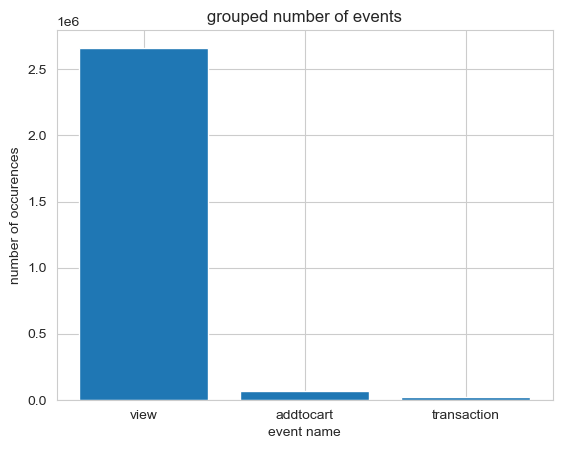

In [19]:
import matplotlib.ticker as ticker
event_counts = events.event.value_counts()
print(event_counts)

plt.bar(event_counts.index, event_counts.values)
plt.title('grouped number of events')
plt.xlabel('event name')
plt.ylabel('number of occurences')

# plt.yticks(event_counts.values)
plt.show()


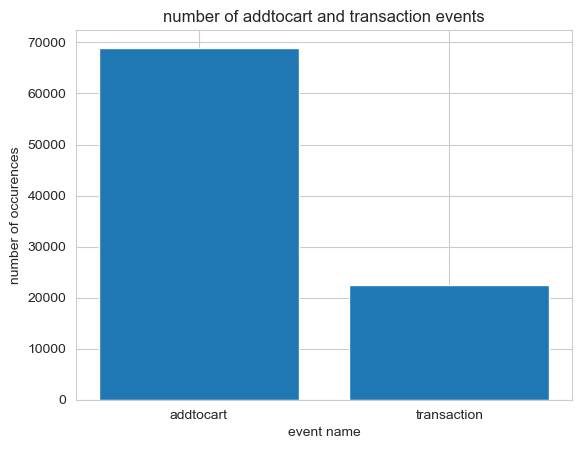

In [20]:
plt.bar(event_counts.index[1:], event_counts.values[1:])
plt.title('number of addtocart and transaction events')
plt.xlabel('event name')
plt.ylabel('number of occurences')

# plt.yticks(event_counts.values)
plt.show()

In [21]:
def sort_array(array):
    unique, counts = np.unique(array, return_counts=True)
    count_view=dict(zip(unique, counts))
    sorted_count_view =sorted(count_view.items(), key=operator.itemgetter(1),reverse=True)
    x=[str(i[0]) for i in sorted_count_view]
    y=[i[1] for i in sorted_count_view]
    return x, y

['187946', '461686', '5411', '370653', '219512'] [3410, 2538, 2325, 1854, 1740]


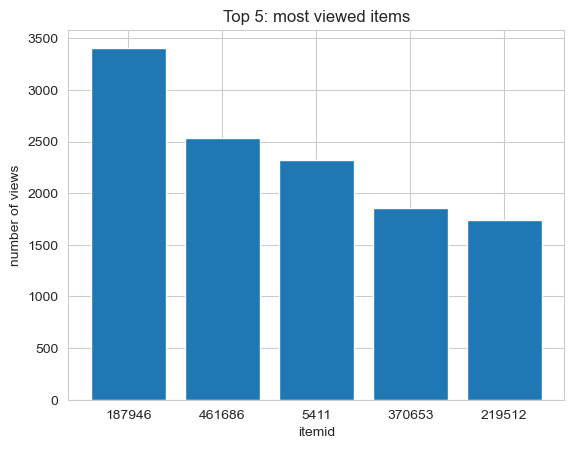

In [22]:
# source https://www.kaggle.com/code/himansh96/eda-e-commerce-dataset
grouped=events.groupby('event')['itemid'].apply(list)

#most viewed items
views=grouped['view']
x, y = sort_array(views)
print(x[:5],y[:5])
plt.bar(x[:5],y[:5], width=0.8)
plt.title('Top 5: most viewed items')
plt.xlabel('itemid')
plt.ylabel('number of views')
plt.show()

['461686', '312728', '409804', '320130', '29196'] [304, 161, 152, 141, 135]


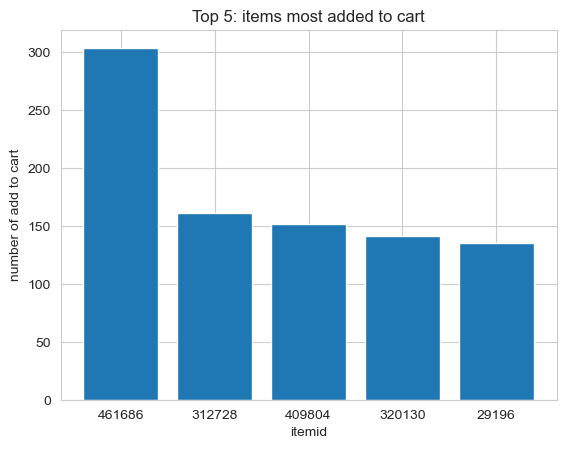

In [23]:
views=grouped['addtocart']
x, y = sort_array(views)
print(x[:5],y[:5])
plt.bar(x[:5],y[:5], width=0.8)
plt.title('Top 5: items most added to cart')
plt.xlabel('itemid')
plt.ylabel('number of add to cart')
plt.show()

['461686', '119736', '213834', '7943', '312728'] [133, 97, 92, 46, 46]


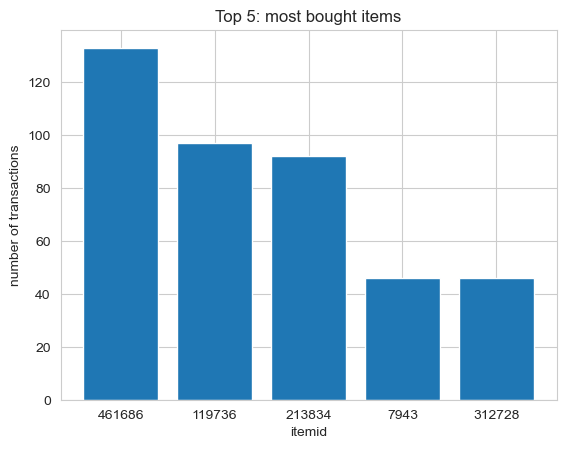

In [24]:
views=grouped['transaction']
x, y = sort_array(views)
print(x[:5],y[:5])
plt.bar(x[:5],y[:5], width=0.8)
plt.title('Top 5: most bought items')
plt.xlabel('itemid')
plt.ylabel('number of transactions')
plt.show()

In [25]:
# source for following graphs https://www.kaggle.com/code/allanyiinai/recommmandation-find-similar-behavior
import datetime
events_copy = events.copy()
events_copy['timestamp']=pd.to_datetime(events_copy['timestamp'],unit='ms')

events_copy['hour'] = events_copy['timestamp'].dt.hour
events_copy['date'] = events_copy['timestamp'].dt.date
events_copy['cnt']=1.0
print(events_copy['timestamp'].min(),events_copy['timestamp'].max())
events_copy

2015-05-03 03:00:04.384000 2015-09-18 02:59:47.788000


,timestamp,visitorid,event,itemid,transactionid,datetime,hour,date,cnt
0,2015-06-02 05:02:12.117,257597,view,355908,NaN,2015-06-02 07:02:12,5,2015-06-02,1.0
1,2015-06-02 05:50:14.164,992329,view,248676,NaN,2015-06-02 07:50:14,5,2015-06-02,1.0
2,2015-06-02 05:13:19.827,111016,view,318965,NaN,2015-06-02 07:13:19,5,2015-06-02,1.0
3,2015-06-02 05:12:35.914,483717,view,253185,NaN,2015-06-02 07:12:35,5,2015-06-02,1.0
4,2015-06-02 05:02:17.106,951259,view,367447,NaN,2015-06-02 07:02:17,5,2015-06-02,1.0
...,...,...,...,...,...,...,...,...,...
2756096,2015-08-01 03:13:05.939,591435,view,261427,NaN,2015-08-01 05:13:05,3,2015-08-01,1.0
2756097,2015-08-01 03:30:13.142,762376,view,115946,NaN,2015-08-01 05:30:13,3,2015-08-01,1.0
2756098,2015-08-01 02:57:00.527,1251746,view,78144,NaN,2015-08-01 04:57:00,2,2015-08-01,1.0
2756099,2015-08-01 03:08:50.703,1184451,view,283392,NaN,2015-08-01 05:08:50,3,2015-08-01,1.0


In [26]:

events_copy['cnt'] = events_copy['cnt'].astype(float)
events_copy['hour'] = events_copy['hour'].astype(int)
#grouped_date_event_no_views = grouped_date_event_no_views[grouped_date_event_no_views['event'] != 'view'].groupby(['date','event'])

events_subset = events_copy[['date', 'event', 'cnt', 'hour']]
events_subset

,date,event,cnt,hour
0,2015-06-02,view,1.0,5
1,2015-06-02,view,1.0,5
2,2015-06-02,view,1.0,5
3,2015-06-02,view,1.0,5
4,2015-06-02,view,1.0,5
...,...,...,...,...
2756096,2015-08-01,view,1.0,3
2756097,2015-08-01,view,1.0,3
2756098,2015-08-01,view,1.0,2
2756099,2015-08-01,view,1.0,3


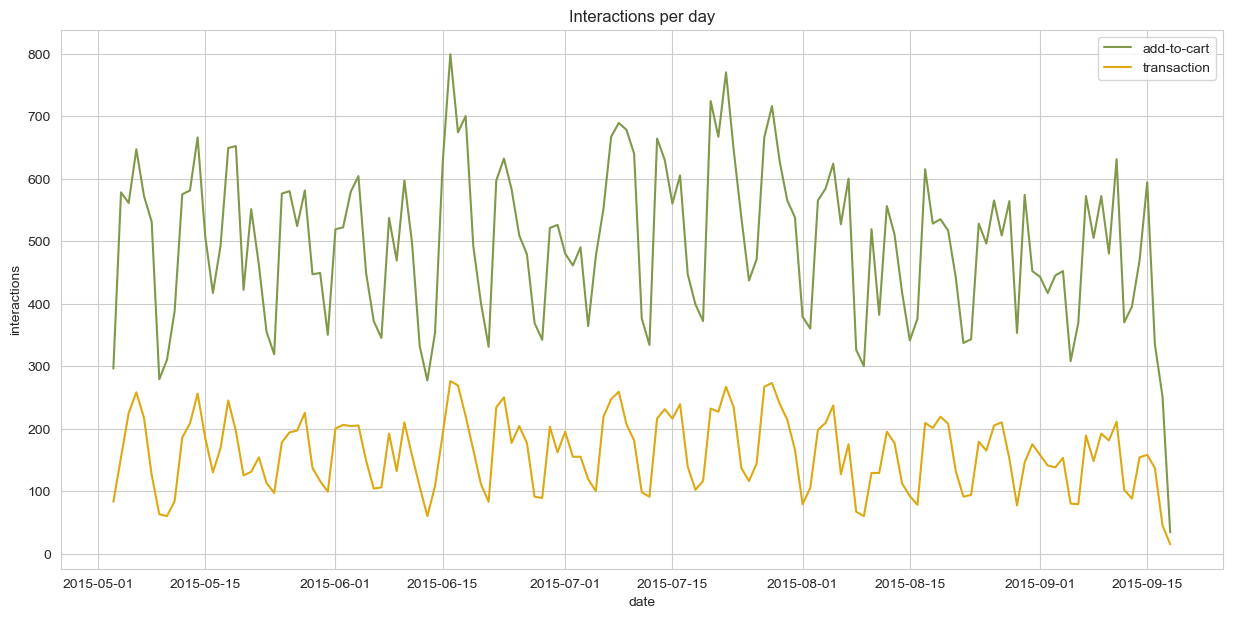

In [27]:
fig, ax = plt.subplots(figsize=(15,7))
plt.title('Interactions per day')
ax.set_xlabel("date")
ax.set_ylabel("interactions")
labels = ['add-to-cart', 'transaction']
events_subset[events_subset['event'] != 'view'].groupby(['date','event']).sum()['cnt'].unstack().plot(ax=ax, color=[color_green, color_orange])
plt.legend(labels)
plt.show()

<Axes: title={'center': 'Interactions per day (no views)'}, xlabel='date'>

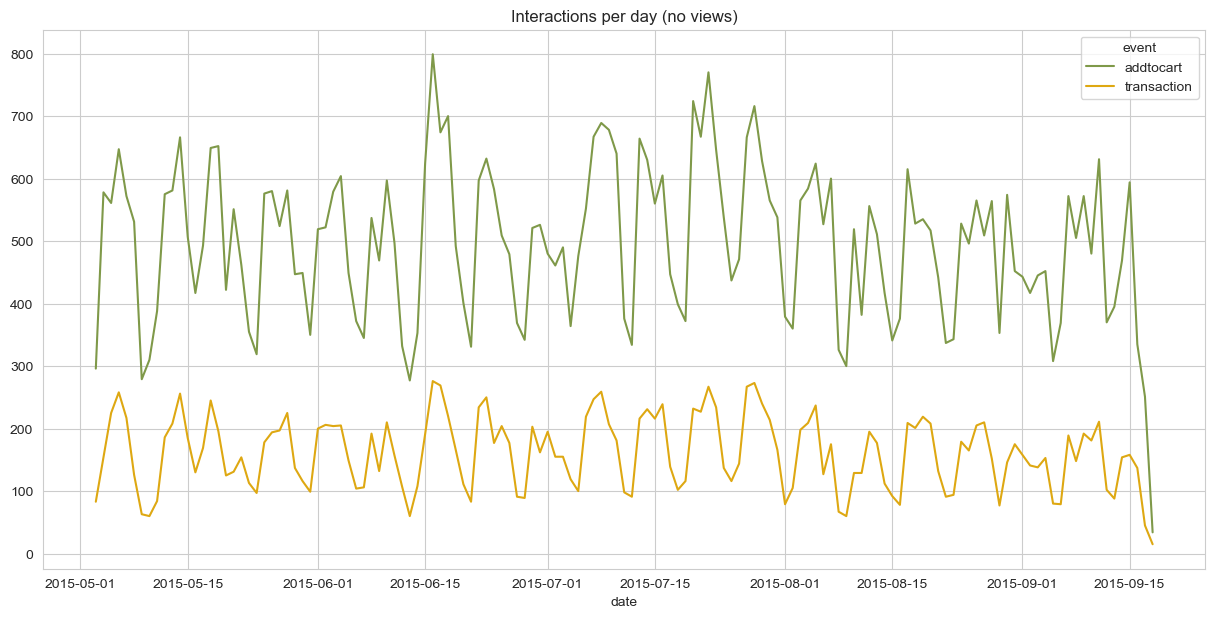

In [28]:
fig, ax = plt.subplots(figsize=(15,7))
plt.title('Interactions per day (no views)')
events_subset[events_subset['event'] != 'view'].groupby(['date','event']).sum()['cnt'].unstack().plot(ax=ax, color=[color_green, color_orange])

<Axes: title={'center': 'interaction by hour (no views)'}, xlabel='hour'>

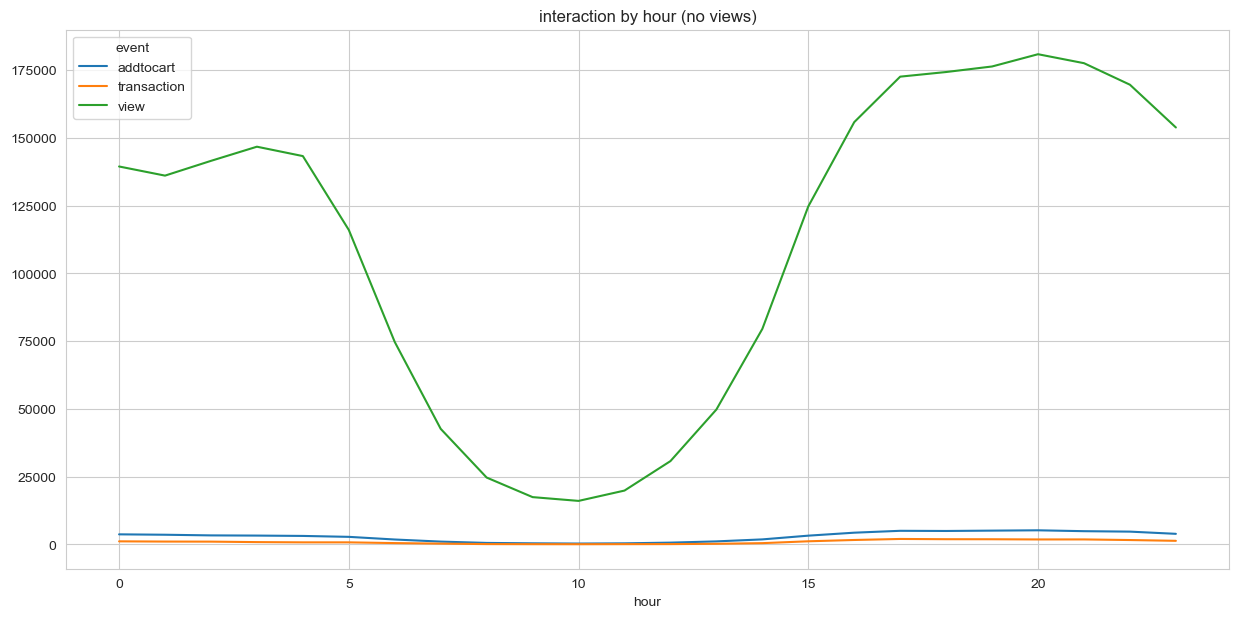

In [29]:
temp_subset = events_subset[['hour', 'event', 'cnt']]
grouped_hour_data = temp_subset.groupby(['hour', 'event']).sum()['cnt']

fig, ax = plt.subplots(figsize=(15,7))
plt.title('interaction by hour (no views)')
grouped_hour_data.unstack().plot(ax=ax)

<Axes: title={'center': 'interaction by hour (no views)'}, xlabel='hour'>

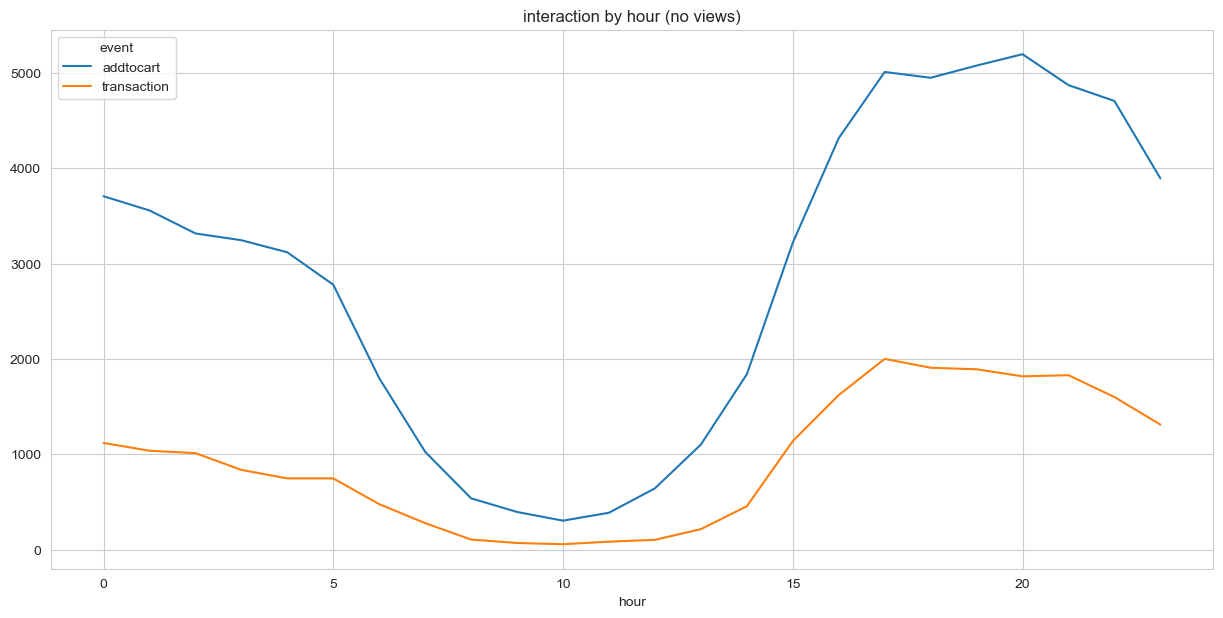

In [30]:
#events_copy[events_copy['event'] != 'view'].groupby(['date', 'event']).sum()['cnt'].unstack().plot(ax=ax)
temp_subset = events_subset[['hour', 'event', 'cnt']]
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('interaction by hour (no views)')
temp_subset[temp_subset['event'] != 'view'].groupby(['hour', 'event']).sum()['cnt'].unstack().plot(ax=ax)

In [31]:
df1=events_copy.groupby(['hour','event','visitorid']).sum(['cnt'])
df1

itemid  transactionid  cnt
hour event     visitorid                             
0    addtocart 172          10034            0.0  1.0
               745         246164            0.0  1.0
               914         382946            0.0  1.0
               1765        330469            0.0  1.0
               2114        342264            0.0  1.0
...                           ...            ...  ...
23   view      1407412     238369            0.0  1.0
               1407423     129764            0.0  3.0
               1407424     584428            0.0  2.0
               1407483     355595            0.0  1.0
               1407527    1194526            0.0  6.0

[1770629 rows x 3 columns]

In [32]:
#https://www.kaggle.com/code/niteshsahujhansi/product-recommendation-system
customer_purchased = events[events.transactionid.notnull()].visitorid.unique()
print('customers who bought something: ', customer_purchased.size)

customers who bought something:  11719


In [33]:
all_customers = events.visitorid.unique()

customer_browsed = [x for x in all_customers if x not in customer_purchased]
print('customers who bought nothing: ',len(customer_browsed))

customers who bought nothing:  1395861


In [34]:
# https://www.kaggle.com/code/shubhamb99/rajani-hackathon
all_bought_events = events.loc[events['visitorid'].isin(customer_purchased)].sort_values('timestamp').reset_index(drop=True)
display(all_bought_events)

,timestamp,visitorid,event,itemid,transactionid,datetime
0,1430622200404,41386,view,340921,NaN,2015-05-03 05:03:20
1,1430622568107,345781,view,438400,NaN,2015-05-03 05:09:28
2,1430622693415,345781,addtocart,438400,NaN,2015-05-03 05:11:33
3,1430622930536,560305,view,43939,NaN,2015-05-03 05:15:30
4,1430623437020,266417,view,445106,NaN,2015-05-03 05:23:57
...,...,...,...,...,...,...
230601,1442544483164,152963,view,311082,NaN,2015-09-18 04:48:03
230602,1442544492421,152963,view,311082,NaN,2015-09-18 04:48:12
230603,1442544526605,152963,view,134455,NaN,2015-09-18 04:48:46
230604,1442544701919,994820,view,440677,NaN,2015-09-18 04:51:41


In [35]:
random_events_df = events.loc[events.visitorid.isin(all_customers)].sort_values('timestamp').reset_index(drop=True)
display(random_events_df)

,timestamp,visitorid,event,itemid,transactionid,datetime
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 05:00:04
1,1430622011289,829044,view,60987,NaN,2015-05-03 05:00:11
2,1430622013048,652699,view,252860,NaN,2015-05-03 05:00:13
3,1430622024154,1125936,view,33661,NaN,2015-05-03 05:00:24
4,1430622026228,693516,view,297662,NaN,2015-05-03 05:00:26
...,...,...,...,...,...,...
2755636,1442545164029,472345,view,301436,NaN,2015-09-18 04:59:24
2755637,1442545165499,1207677,view,310922,NaN,2015-09-18 04:59:25
2755638,1442545174109,255126,view,47467,NaN,2015-09-18 04:59:34
2755639,1442545181778,622226,view,345308,NaN,2015-09-18 04:59:41


In [36]:
#https://www.kaggle.com/code/shubhamb99/rajani-hackathon

# Since there are variations in pattern of events leading to transaction, let's see the relation between different events
# Some probable events we want to look at:
# 1. How many times products were viewed
# 2. How many products were viewed
# 3. How many products were added to cart
# 4. How many products were transacted

# A more accurate study would be on (user, product) combination rather than just user. But this is good for the time being.

all_visitors_data = []
for visitor in random_events_df.visitorid.unique().tolist():
    visitor_data = []
    visitor_df = random_events_df.loc[random_events_df['visitorid']==visitor]

    visitor_data.append(visitor)

    # See how many products were viewed
    visitor_data.append(visitor_df.itemid.nunique())

    # Add details about transactions
    visitor_data.append(visitor_df.loc[visitor_df['event']=='view'].shape[0])
    visitor_data.append(visitor_df.loc[visitor_df['event']=='addtocart'].shape[0])
    visitor_data.append(visitor_df.loc[visitor_df['event']=='transaction'].shape[0])

    all_visitors_data.append(visitor_data)

transformed_events_df = pd.DataFrame(all_visitors_data, columns=['visitorid', 'products_viewed', 'num_views', 'num_add2cart', 'num_transaction'])

display(transformed_events_df)

,visitorid,products_viewed,num_views,num_add2cart,num_transaction
0,693516,1,1,2,0
1,829044,1,1,0,0
2,652699,1,1,0,0
3,1125936,1,1,0,0
4,1149227,1,1,0,0
...,...,...,...,...,...
1407575,998517,1,1,0,0
1407576,472345,1,1,0,0
1407577,1207677,1,1,0,0
1407578,255126,1,1,0,0


In [37]:
summary_df = pd.merge(random_events_df, pd.get_dummies(random_events_df['event']), left_index=True, right_index=True).drop(columns=['event'])
display(summary_df)

,timestamp,visitorid,itemid,transactionid,datetime,addtocart,transaction,view
0,1430622004384,693516,297662,NaN,2015-05-03 05:00:04,True,False,False
1,1430622011289,829044,60987,NaN,2015-05-03 05:00:11,False,False,True
2,1430622013048,652699,252860,NaN,2015-05-03 05:00:13,False,False,True
3,1430622024154,1125936,33661,NaN,2015-05-03 05:00:24,False,False,True
4,1430622026228,693516,297662,NaN,2015-05-03 05:00:26,False,False,True
...,...,...,...,...,...,...,...,...
2755636,1442545164029,472345,301436,NaN,2015-09-18 04:59:24,False,False,True
2755637,1442545165499,1207677,310922,NaN,2015-09-18 04:59:25,False,False,True
2755638,1442545174109,255126,47467,NaN,2015-09-18 04:59:34,False,False,True
2755639,1442545181778,622226,345308,NaN,2015-09-18 04:59:41,False,False,True


In [38]:
# For each (visitor, item) pair, let's create a study of:
# 1. Number of times viewed
# 2. Added to cart?
# 3. Transaction done?

product_item_df = summary_df.groupby(by=['itemid', 'visitorid']).agg({'view': 'sum', 'addtocart': 'sum', 'transaction': 'sum'}).reset_index()
display(product_item_df)

,itemid,visitorid,view,addtocart,transaction
0,3,370720,1,0,0
1,3,639016,1,0,0
2,4,905555,1,0,0
3,4,1010132,1,0,0
4,4,1042455,1,0,0
...,...,...,...,...,...
2145174,466864,1388296,4,0,0
2145175,466867,241803,1,0,0
2145176,466867,450511,1,0,0
2145177,466867,1001859,1,0,0


## Item Properties EDA

### Item Properties extraction

as for each item property a single row exists and every item category can exits multiple times, as it may change overtime in the following cells the properties are extracted. So that for every item only the newest properties exist. Further the newest categoryid and available are extracted into a separate column

In [39]:
item_properties

,timestamp,itemid,property,value,datetime
0,1435460400000,460429,categoryid,1338,2015-06-28 05:00:00
1,1441508400000,206783,888,1116713 960601 n277.200,2015-09-06 05:00:00
2,1439089200000,395014,400,n552.000 639502 n720.000 424566,2015-08-09 05:00:00
3,1431226800000,59481,790,n15360.000,2015-05-10 05:00:00
4,1431831600000,156781,917,828513,2015-05-17 05:00:00
...,...,...,...,...,...
9275898,1433646000000,236931,929,n12.000,2015-06-07 05:00:00
9275899,1440903600000,455746,6,150169 639134,2015-08-30 05:00:00
9275900,1439694000000,347565,686,610834,2015-08-16 05:00:00
9275901,1433646000000,287231,867,769062,2015-06-07 05:00:00


In [40]:
item_properties2 = item_properties.copy() # copy so the orginal data does not change
item_properties2['timestamp'] = pd.to_datetime(item_properties2['timestamp'], unit='ms')

# Extract 'categoryid' and 'available' properties
filtered_data = item_properties2[~item_properties2['property'].isin(['categoryid', 'available'])]

In [41]:
# Sort the data by timestamp in descending order
sorted_data = filtered_data.sort_values('timestamp', ascending=False)

In [42]:
# todo delete
# Iterate over each property and extract the newest item per property
aggregated_data = {}
for prop in sorted_data['property'].unique():
    # Filter the data for the current property
    prop_data = sorted_data[sorted_data['property'] == prop]
    # Group the data by itemid and select the first row for each group
    grouped_data = prop_data.groupby('itemid').first().reset_index()
    # Store the aggregated data for the property
    aggregated_data[prop] = grouped_data.set_index('itemid')['value']
#display(aggregated_data)

In [43]:
# Merge categoryid and available values and only use the newest value
merged_data = pd.merge(item_properties2[item_properties2['property'] == 'categoryid'], item_properties2[item_properties2['property'] == 'available'], on='itemid')
merged_data = merged_data[['itemid', 'value_x', 'value_y']].rename(columns={'value_x': 'categoryid', 'value_y': 'available'})
merged_data = merged_data.groupby('itemid').first().reset_index()
# add columns with a lists for the properties
merged_data['properties'] = [[] for _ in range(len(merged_data))]
merged_data['property_values'] = [[] for _ in range(len(merged_data))]
merged_data

,itemid,categoryid,available,properties,property_values
0,0,209,0,[],[]
1,1,1114,1,[],[]
2,2,1305,0,[],[]
3,3,1171,0,[],[]
4,4,1038,0,[],[]
...,...,...,...,...,...
417048,466862,1376,0,[],[]
417049,466863,173,0,[],[]
417050,466864,373,1,[],[]
417051,466865,421,0,[],[]


In [44]:
# store the properties into the merged_data, this might take a while :D
for item_id in item_properties.itemid.unique():
    for prop_id, row in sorted_data[sorted_data['itemid'] == item_id].groupby('property').first().iterrows():
        merged_data.loc[merged_data['itemid'] == item_id].properties.apply(lambda x: x.append(prop_id))
        merged_data.loc[merged_data['itemid'] == item_id].property_values.apply(lambda x: x.append(row['value']))

merged_data

,itemid,categoryid,available,properties,property_values
0,0,209,0,"[1036, 1056, 11, 112, 127, 139, 159, 177, 189,...","[1276750, n3.168 1144008, n15360.000 628176 n1..."
1,1,1114,1,"[0, 1036, 112, 159, 185, 202, 227, 238, 280, 2...","[769062, 1154859, 679677, 519769, 769062, 1726..."
2,2,1305,0,"[1063, 112, 159, 202, 282, 283, 318, 332, 364,...","[n396.000 145688, 679677, 519769, 648485 n6000..."
3,3,1171,0,"[1025, 1080, 112, 159, 202, 227, 250, 283, 30,...","[769062, 769062, 679677, 519769, 261419, 13057..."
4,4,1038,0,"[112, 115, 159, 202, 227, 28, 283, 33, 364, 59...","[679677, n24.000, 519769, 371058 71429, 588652..."
...,...,...,...,...,...
417048,466862,1376,0,"[112, 139, 159, 186, 202, 227, 28, 283, 29, 34...","[679677, 769062, 519769, 575816 n432.000, 7173..."
417049,466863,173,0,"[1014, 112, 159, 202, 227, 283, 364, 400, 47, ...","[1075463, 679677, 519769, 1194687 550565 24255..."
417050,466864,373,1,"[1036, 112, 152, 159, 202, 227, 230, 283, 348,...","[1154859, 679677, 1071492, 519769, 1262739 205..."
417051,466865,421,0,"[1031, 112, 159, 202, 227, 277, 28, 283, 332, ...","[1088309, 679677, 519769, 150169 780351 820477..."


In [45]:
for item_id in item_properties.itemid.unique():
    item_rows = sorted_data[sorted_data['itemid'] == item_id]
    properties = item_rows.groupby('property').first()
    property_values = item_rows.set_index('property')['value']
    for prop_id in properties.index:
        merged_data.loc[merged_data['itemid'] == item_id, 'properties'].iloc[0].append(prop_id)
        merged_data.loc[merged_data['itemid'] == item_id, 'property_values'].iloc[0].append(property_values[prop_id])

merged_data

,itemid,categoryid,available,properties,property_values
0,0,209,0,"[1036, 1056, 11, 112, 127, 139, 159, 177, 189,...","[1276750, n3.168 1144008, n15360.000 628176 n1..."
1,1,1114,1,"[0, 1036, 112, 159, 185, 202, 227, 238, 280, 2...","[769062, 1154859, 679677, 519769, 769062, 1726..."
2,2,1305,0,"[1063, 112, 159, 202, 282, 283, 318, 332, 364,...","[n396.000 145688, 679677, 519769, 648485 n6000..."
3,3,1171,0,"[1025, 1080, 112, 159, 202, 227, 250, 283, 30,...","[769062, 769062, 679677, 519769, 261419, 13057..."
4,4,1038,0,"[112, 115, 159, 202, 227, 28, 283, 33, 364, 59...","[679677, n24.000, 519769, 371058 71429, 588652..."
...,...,...,...,...,...
417048,466862,1376,0,"[112, 139, 159, 186, 202, 227, 28, 283, 29, 34...","[679677, 769062, 519769, 575816 n432.000, 7173..."
417049,466863,173,0,"[1014, 112, 159, 202, 227, 283, 364, 400, 47, ...","[1075463, 679677, 519769, 1194687 550565 24255..."
417050,466864,373,1,"[1036, 112, 152, 159, 202, 227, 230, 283, 348,...","[1154859, 679677, 1071492, 519769, 1262739 205..."
417051,466865,421,0,"[1031, 112, 159, 202, 227, 277, 28, 283, 332, ...","[1088309, 679677, 519769, 150169 780351 820477..."


In [46]:
display(merged_data)

,itemid,categoryid,available,properties,property_values
0,0,209,0,"[1036, 1056, 11, 112, 127, 139, 159, 177, 189,...","[1276750, n3.168 1144008, n15360.000 628176 n1..."
1,1,1114,1,"[0, 1036, 112, 159, 185, 202, 227, 238, 280, 2...","[769062, 1154859, 679677, 519769, 769062, 1726..."
2,2,1305,0,"[1063, 112, 159, 202, 282, 283, 318, 332, 364,...","[n396.000 145688, 679677, 519769, 648485 n6000..."
3,3,1171,0,"[1025, 1080, 112, 159, 202, 227, 250, 283, 30,...","[769062, 769062, 679677, 519769, 261419, 13057..."
4,4,1038,0,"[112, 115, 159, 202, 227, 28, 283, 33, 364, 59...","[679677, n24.000, 519769, 371058 71429, 588652..."
...,...,...,...,...,...
417048,466862,1376,0,"[112, 139, 159, 186, 202, 227, 28, 283, 29, 34...","[679677, 769062, 519769, 575816 n432.000, 7173..."
417049,466863,173,0,"[1014, 112, 159, 202, 227, 283, 364, 400, 47, ...","[1075463, 679677, 519769, 1194687 550565 24255..."
417050,466864,373,1,"[1036, 112, 152, 159, 202, 227, 230, 283, 348,...","[1154859, 679677, 1071492, 519769, 1262739 205..."
417051,466865,421,0,"[1031, 112, 159, 202, 227, 277, 28, 283, 332, ...","[1088309, 679677, 519769, 150169 780351 820477..."


# options stuff

### basic RS

In [47]:
#lets define the function that would show items that were bought together by the same customer
#https://www.kaggle.com/code/niteshsahujhansi/product-recommendation-system

# first - lets create a list of visitors who made a purchase
# customer_purchased = events[events.transactionid.notnull()].visitorid.unique()
#
# #lets create a list of purchased items
# purchased_items = []
#
# for customer in customer_purchased:
#     purchased_items.append(list(events.loc[(events.visitorid == customer) & (events.transactionid.notnull())].itemid.values))
#


In [48]:
# def recommend_items(item_id, purchased_items):
#     recommendation_list =[]
#     for x in purchased_items:
#         if item_id in x:
#             recommendation_list +=x
#
#     # remove the pass item from the list and merge the above created list
#     recommendation_list = list(set(recommendation_list) - set([item_id]))
#     return recommendation_list

# recommend_items(200793, purchased_items)

In [49]:
merged_data

,itemid,categoryid,available,properties,property_values
0,0,209,0,"[1036, 1056, 11, 112, 127, 139, 159, 177, 189,...","[1276750, n3.168 1144008, n15360.000 628176 n1..."
1,1,1114,1,"[0, 1036, 112, 159, 185, 202, 227, 238, 280, 2...","[769062, 1154859, 679677, 519769, 769062, 1726..."
2,2,1305,0,"[1063, 112, 159, 202, 282, 283, 318, 332, 364,...","[n396.000 145688, 679677, 519769, 648485 n6000..."
3,3,1171,0,"[1025, 1080, 112, 159, 202, 227, 250, 283, 30,...","[769062, 769062, 679677, 519769, 261419, 13057..."
4,4,1038,0,"[112, 115, 159, 202, 227, 28, 283, 33, 364, 59...","[679677, n24.000, 519769, 371058 71429, 588652..."
...,...,...,...,...,...
417048,466862,1376,0,"[112, 139, 159, 186, 202, 227, 28, 283, 29, 34...","[679677, 769062, 519769, 575816 n432.000, 7173..."
417049,466863,173,0,"[1014, 112, 159, 202, 227, 283, 364, 400, 47, ...","[1075463, 679677, 519769, 1194687 550565 24255..."
417050,466864,373,1,"[1036, 112, 152, 159, 202, 227, 230, 283, 348,...","[1154859, 679677, 1071492, 519769, 1262739 205..."
417051,466865,421,0,"[1031, 112, 159, 202, 227, 277, 28, 283, 332, ...","[1088309, 679677, 519769, 150169 780351 820477..."


## Save preprocessed dataframes

In [50]:
basepath = '../datasets/preprocessed_datasets/retailrocket/'
events.to_pickle(basepath + 'events.pkl')
item_properties.to_pickle(basepath + 'item_properties.pkl') 
category_tree.to_pickle(basepath + 'category_tree.pkl')


In [51]:
transformed_events_df.to_pickle(basepath + 'visitor_actions.pkl')

In [52]:
product_item_df.to_pickle(basepath + 'product_item.pkl')

In [53]:
merged_data

,itemid,categoryid,available,properties,property_values
0,0,209,0,"[1036, 1056, 11, 112, 127, 139, 159, 177, 189,...","[1276750, n3.168 1144008, n15360.000 628176 n1..."
1,1,1114,1,"[0, 1036, 112, 159, 185, 202, 227, 238, 280, 2...","[769062, 1154859, 679677, 519769, 769062, 1726..."
2,2,1305,0,"[1063, 112, 159, 202, 282, 283, 318, 332, 364,...","[n396.000 145688, 679677, 519769, 648485 n6000..."
3,3,1171,0,"[1025, 1080, 112, 159, 202, 227, 250, 283, 30,...","[769062, 769062, 679677, 519769, 261419, 13057..."
4,4,1038,0,"[112, 115, 159, 202, 227, 28, 283, 33, 364, 59...","[679677, n24.000, 519769, 371058 71429, 588652..."
...,...,...,...,...,...
417048,466862,1376,0,"[112, 139, 159, 186, 202, 227, 28, 283, 29, 34...","[679677, 769062, 519769, 575816 n432.000, 7173..."
417049,466863,173,0,"[1014, 112, 159, 202, 227, 283, 364, 400, 47, ...","[1075463, 679677, 519769, 1194687 550565 24255..."
417050,466864,373,1,"[1036, 112, 152, 159, 202, 227, 230, 283, 348,...","[1154859, 679677, 1071492, 519769, 1262739 205..."
417051,466865,421,0,"[1031, 112, 159, 202, 227, 277, 28, 283, 332, ...","[1088309, 679677, 519769, 150169 780351 820477..."


In [54]:
basepath = '../datasets/preprocessed_datasets/retailrocket/'
merged_data.to_pickle(basepath + 'item_data_extracted.pkl')
merged_data.to_csv(basepath + 'item_data_extracted.csv')

In [55]:
events = events.sample(10000)
events.to_pickle(basepath + 'events_10k.pkl')